# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

> ##### Data Problem Definition
> 
> We are to find the causal features of the target feature price. This will be a regression problem with the `price` feature as the target with other features used as the explanatory features. Each example represent the sale of a car. Some may be the repeat sales of the same car.



### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

> ##### Steps to understanding the data
> 
> - Read the data dictionary, if present
> - Investigate the schema of the data
> - Investigate missing values
> - Investigate the target variable (definition, descriptive stats/distribution, outliers, etc.)
> - Investigate the possible explanitory features (definitions, descriptive stats/distributions, correlations)

In [1]:
# ********************************************************************
# Notes:
# - I am using an additional package for descriptive analysis, pyskim
# ********************************************************************

# Import Pandas
import pandas as pd
import numpy as np
import numpy.random as rng

# Import Seaborn
import seaborn as sns
import seaborn.objects as so
sns.set_theme(style='darkgrid', palette='tab10')
sns.set(rc={'figure.figsize':(10,6)})
import matplotlib.pyplot as plt

# Import skim function for descriptive analysis
from pyskim import skim

# Scikit Learn Imports
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer


In [2]:
# Read in the dataset
raw_vehicles = pd.read_csv('data/vehicles.csv')

# Look at the default data types
raw_vehicles.dtypes

id                int64
region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object

In [3]:
# Investigate the missing values
raw_vehicles.isna().sum()/raw_vehicles.shape[0]

id              0.000000
region          0.000000
price           0.000000
year            0.002823
manufacturer    0.041337
model           0.012362
condition       0.407852
cylinders       0.416225
fuel            0.007058
odometer        0.010307
title_status    0.019308
transmission    0.005988
VIN             0.377254
drive           0.305863
size            0.717675
type            0.217527
paint_color     0.305011
state           0.000000
dtype: float64

##### Missing Values Conclusions

- There are a number of columns with signficant number of missing values
    - condition: ~41%
    - cylinders: ~42%
    - VIN: ~38%
    - drive: ~30%
    - size: ~70%
    - type: ~21%
    - paint_color: ~30%

In [4]:
# Perform an intial descriptive analysis using pyskim
skim(raw_vehicles)

── Data Summary ────────────────────────────────────────────────────────────────────────────────────
type                 value
-----------------  -------
Number of rows      426880
Number of columns       18
──────────────────────────────────────────────────
Column type frequency:
           Count
-------  -------
object        14
int64          2
float64        2

── Variable type: number ───────────────────────────────────────────────────────────────────────────
    name        na_count      mean        sd        p0       p25       p50       p75      p100  hist
--  --------  ----------  --------  --------  --------  --------  --------  --------  --------  ----------
 0  id                 0  7.31e+09  4.47e+06  7.21e+09  7.31e+09  7.31e+09  7.32e+09  7.32e+09  ▁▁▁▁▁▁▁▁▂▇
 1  price              0  7.52e+04  1.22e+07  0         5.9e+03   1.4e+04   2.65e+04  3.74e+09  ▇▁▁▁▁▁▁▁▁▁
 2  year            1205  2.01e+03  9.45      1.9e+03   2.01e+03  2.01e+03  2.02e+03  2.02e+03  ▁▁▁▁▁▁▁▁▃▇
 

##### Descriptive Analysis Conclusions

- There are some very high cardinality categorical variables
    - region: 404
    - model: 29649
    - VIN: 118246
- There are some moderately high cardinality variables
    - Manafacturer: 42
    - state: 51




[Text(-500000000.0, 0, '$-500,000'),
 Text(0.0, 0, '$0'),
 Text(500000000.0, 0, '$500,000'),
 Text(1000000000.0, 0, '$1,000,000'),
 Text(1500000000.0, 0, '$1,500,000'),
 Text(2000000000.0, 0, '$2,000,000'),
 Text(2500000000.0, 0, '$2,500,000'),
 Text(3000000000.0, 0, '$3,000,000'),
 Text(3500000000.0, 0, '$3,500,000'),
 Text(4000000000.0, 0, '$4,000,000')]

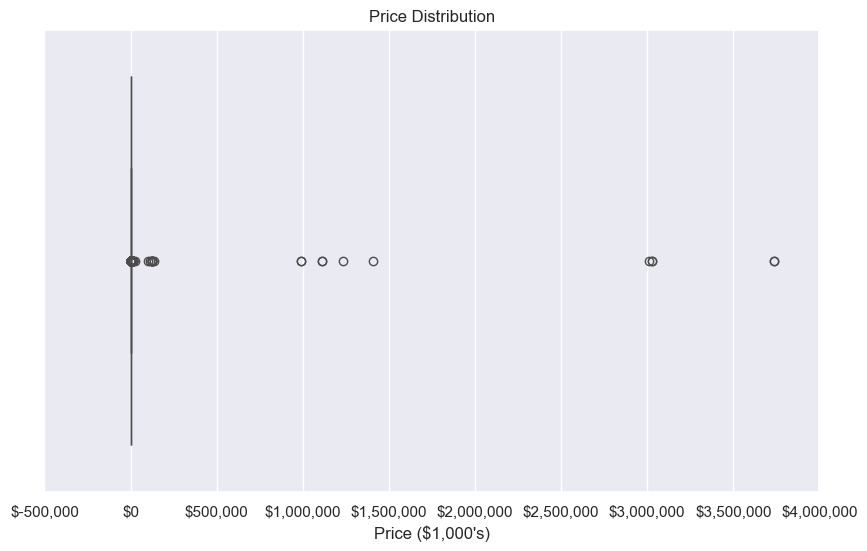

In [5]:
# Investigate the target variable price
ax = sns.boxplot(raw_vehicles, x='price')
ax.set_title('Price Distribution')
ax.set_xlabel('Price ($1,000\'s)')

# Format the x ticks
ax.xaxis.set_ticks(ax.get_xticks())
ax.set_xticklabels(['${:,}'.format(int(x/1000)) for x in ax.get_xticks().tolist()])


> ##### Target Varible Conclusions
> 
> - The target variable is very skewed.
> - There are some target values that are unreasonble and outliers.
> - The max value is over 3.5 billion dollars
> - These could be due to entry mistakes, missing decimals etc.
> - Cleaning will likely be needed

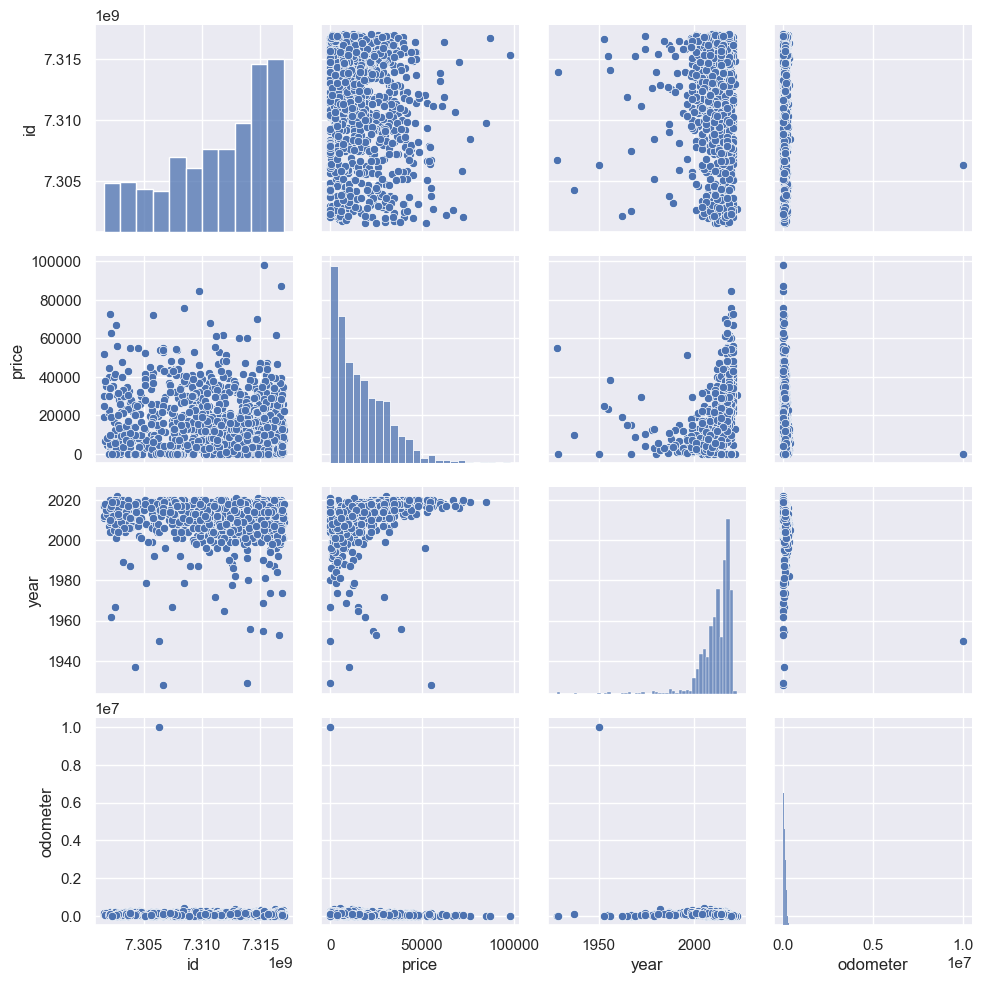

In [6]:
# Investigate the other features
sns.pairplot(raw_vehicles.sample(1000))

10000000.0

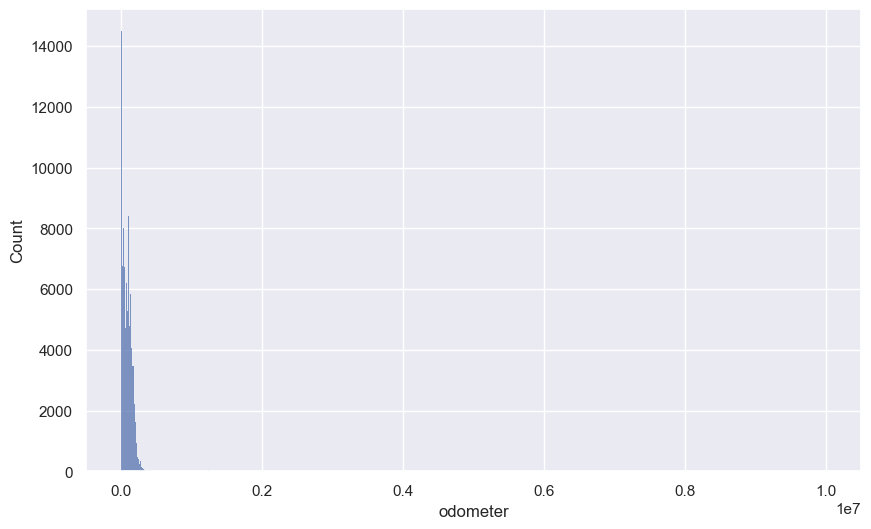

In [7]:
# Investigate Odometer

sns.histplot(raw_vehicles, x='odometer')
raw_vehicles['odometer'].max()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [8]:
# Drop columns unrelated to price
vehicles = raw_vehicles.drop(['id','VIN'], axis=1)

In [9]:
# Handle missing values 

# Drop columns with more the 10% missing values)
cols_to_drop = (vehicles.isna().sum()/vehicles.shape[0] <= .1)
vehicles = vehicles.loc[:, cols_to_drop]
display(vehicles.shape)
vehicles.isna().sum()/vehicles.shape[0]

# Drop the remaining observations that have missing values
vehicles = vehicles.dropna()
vehicles.isna().sum()

(426880, 10)

region          0
price           0
year            0
manufacturer    0
model           0
fuel            0
odometer        0
title_status    0
transmission    0
state           0
dtype: int64

In [10]:
# Exclude outliers in the target variable, using quantiles of .9999 and .0001
display(vehicles.shape)
vehicles = vehicles[(vehicles['price'] <= vehicles['price'].quantile(.99)) &
                    (vehicles['price'] >= vehicles['price'].quantile(.01))]
skim(vehicles)




(389604, 10)

── Data Summary ────────────────────────────────────────────────────────────────────────────────────
type                 value
-----------------  -------
Number of rows      385786
Number of columns       10
──────────────────────────────────────────────────
Column type frequency:
           Count
-------  -------
object         7
float64        2
int64          1

── Variable type: number ───────────────────────────────────────────────────────────────────────────
    name        na_count      mean        sd       p0       p25       p50       p75      p100  hist
--  --------  ----------  --------  --------  -------  --------  --------  --------  --------  ----------
 0  price              0  1.69e+04  1.36e+04  0        6e+03     1.4e+04   2.6e+04   6.5e+04   ▇▆▄▄▃▂▁▁▁▁
 1  year               0  2.01e+03  8.58      1.9e+03  2.01e+03  2.01e+03  2.02e+03  2.02e+03  ▁▁▁▁▁▁▁▁▃▇
 2  odometer           0  9.7e+04   1.92e+05  0        3.9e+04   8.67e+04  1.34e+05  1e+07     ▇▁▁▁▁▁▁▁▁▁

── Va

In [11]:
# Transform price and odometer using logs
X = vehicles.drop('price', axis=1)
y = np.log1p(vehicles['price'])

# Transform the odometer using logs
X = X.drop('odometer', axis=1)
X['log1p_odom'] = np.log1p(vehicles['odometer'])

In [12]:
# Add a Onehot encoder for title status
X_ts = X[['title_status']]
ohe = OneHotEncoder(drop='if_binary')
X_ts = ohe.fit_transform(X_ts).toarray()

# Merge back one hot encoded variables back with numerics
X = np.concatenate([X[['log1p_odom','year']], X_ts], axis=1)
X = pd.DataFrame(X, columns=['log1p_odom', 'year'] + ohe.get_feature_names_out().tolist())

In [13]:
# Add some polynomial features
X_od = X[['log1p_odom']]
pf = PolynomialFeatures(degree=3, include_bias=False)
od_pf = pf.fit_transform(X_od)

# Merge back into X
od_pf = np.delete(od_pf, 0, 1)
X_arr = np.concatenate([X, od_pf], axis=1)
X_final = pd.DataFrame(X_arr, columns=list(X.columns) + pf.get_feature_names_out().tolist()[1:])

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [14]:
# Create Train Test Splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

In [15]:
# Simple Linear Regression
X1 = X_train[['log1p_odom','year']]
lr1 = LinearRegression().fit(X1, y_train)
model_1_train_mse = mean_squared_error(y_train, lr1.predict(X1))
model_1_test_mse = mean_squared_error(y_test, lr1.predict(X_test[['log1p_odom', 'year']]))

# Print MSEs
print(f'Train MSE: {model_1_train_mse: .2f}')
print(f'Test MSE: {model_1_test_mse: .2f}')

Train MSE:  7.37
Test MSE:  7.32


In [16]:
# Simple Linear Regression
X2 = X_train
lr2 = LinearRegression().fit(X2, y_train)
model_2_train_mse = mean_squared_error(y_train, lr2.predict(X2))
model_2_test_mse = mean_squared_error(y_test, lr2.predict(X_test))

# Print MSEs
print(f'Train MSE: {model_2_train_mse: .2f}')
print(f'Test MSE: {model_2_test_mse: .2f}')

Train MSE:  7.36
Test MSE:  7.32


In [17]:
# Initialize
mse_results = []

for n_features in range(1, X.shape[1]):
    
    # Select the best features
    sfs = SequentialFeatureSelector(LinearRegression(), 
                                    scoring='neg_mean_squared_error',
                                    n_features_to_select=n_features,
                                    direction='backward')
    sfs = sfs.fit(X_train, y_train)
    X3 = X_train.loc[:,sfs.get_support()]
    selected_features = X_train.columns[sfs.get_support()].to_list()

    # Run the regression and get the MSEs
    lr = LinearRegression().fit(X3, y_train)
    mse_train = mean_squared_error(y_train, lr.predict(X3))
    mse_test = mean_squared_error(y_test, lr.predict(X_test.loc[:,sfs.get_support()]))
    mse_results.append((f'Model {n_features}',
                       n_features,
                       mse_train,
                       mse_test,
                       mse_test - mse_train,
                       selected_features
                       ))
    
mse_results = pd.DataFrame(mse_results, columns=['Model', 'n_features', 'mse_train', 'mse_test', 'mse_diff',
                                                 'selected_features']).sort_values(by=['mse_test'])

mse_results

,Model,n_features,mse_train,mse_test,mse_diff,selected_features
6,Model 7,7,7.358487,7.316639,-0.041848,"[log1p_odom, year, title_status_lien, title_st..."
5,Model 6,6,7.358492,7.316658,-0.041834,"[log1p_odom, year, title_status_lien, title_st..."
4,Model 5,5,7.359283,7.317590,-0.041693,"[log1p_odom, year, title_status_lien, title_st..."
3,Model 4,4,7.360501,7.318595,-0.041906,"[log1p_odom, year, title_status_lien, title_st..."
2,Model 3,3,7.362732,7.320324,-0.042407,"[log1p_odom, year, title_status_lien]"
1,Model 2,2,7.365458,7.323564,-0.041895,"[log1p_odom, year]"
0,Model 1,1,7.369061,7.327672,-0.041389,[year]


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

> #### Intial Findings
> 
> - The primary driver of the value of a used car is the age
> - Other factors also contribute, like the odometer reading.
> - There are some effects seen from the title status, appear to have a lesser impact on
>   the price.
  

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

# Drivers of Used Car Prices

## Age is the Primary Driver

The price of the car increases as the model year of the car increases. This is likely somewhat
indicative of the condition, some of the features available, etc. The model year is infact the
biggest determinant of used car price from our analysis. Looking at the chart, it would also apppear
that as cars get very old some can have good value. We can posit that perhaps some become collectible
in nature.

[Text(0, -10000.0, '$-10,000'),
 Text(0, 0.0, '$0'),
 Text(0, 10000.0, '$10,000'),
 Text(0, 20000.0, '$20,000'),
 Text(0, 30000.0, '$30,000'),
 Text(0, 40000.0, '$40,000'),
 Text(0, 50000.0, '$50,000'),
 Text(0, 60000.0, '$60,000'),
 Text(0, 70000.0, '$70,000')]

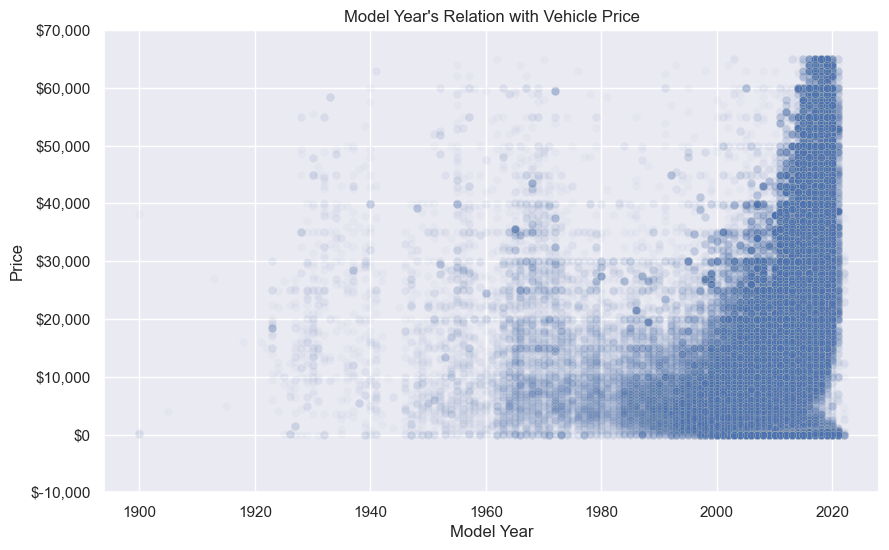

In [18]:
# Create chart of Model Year
ax = sns.scatterplot(vehicles, x='year', y='price', alpha=.04)
ax.set_title('Model Year\'s Relation with Vehicle Price')
ax.set_xlabel('Model Year')
ax.set_ylabel('Price')

# Format the x ticks
ax.yaxis.set_ticks(ax.get_yticks())
ax.set_yticklabels(['${:,}'.format(int(y)) for y in ax.get_yticks().tolist()])

## Odometer Reading

The odometer is inversely related with the price, meaning the more the car has been driven the less it is
generally worth. It is also very interesting to note the precipitous drop off in car value in the first
2000 miles driven. This would support the conventional wisdom that "the car's value declines a lot
the moment you drive it off the lot".

[Text(0, -10000.0, '$-10,000'),
 Text(0, 0.0, '$0'),
 Text(0, 10000.0, '$10,000'),
 Text(0, 20000.0, '$20,000'),
 Text(0, 30000.0, '$30,000'),
 Text(0, 40000.0, '$40,000'),
 Text(0, 50000.0, '$50,000'),
 Text(0, 60000.0, '$60,000'),
 Text(0, 70000.0, '$70,000')]

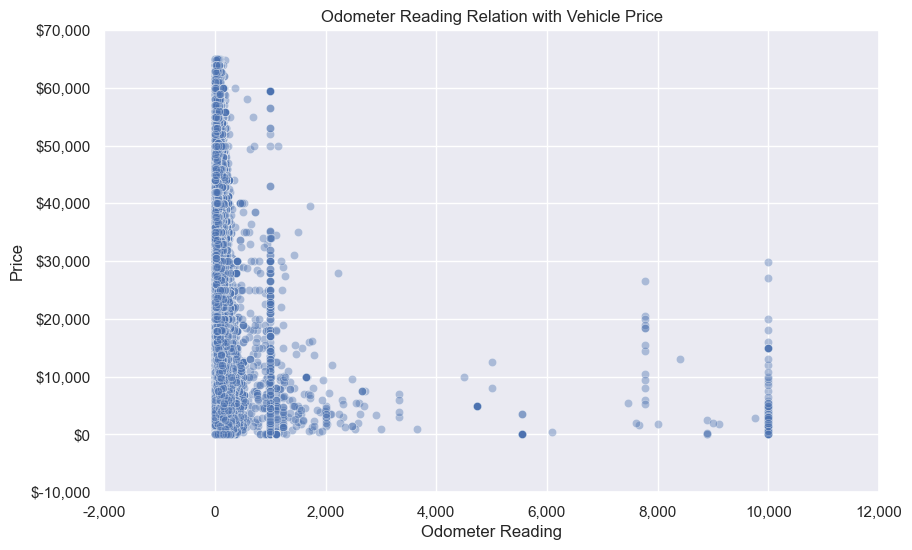

In [19]:
# Create chart of Model Year
ax = sns.scatterplot(vehicles, x='odometer', y='price', alpha=.4)
ax.set_title('Odometer Reading Relation with Vehicle Price')
ax.set_xlabel('Odometer Reading')
ax.set_ylabel('Price')

# Format the x ticks
ax.xaxis.set_ticks(ax.get_xticks())
ax.set_xticklabels(['{:,}'.format(int(x/1000)) for x in ax.get_xticks().tolist()])

# Format the x ticks
ax.yaxis.set_ticks(ax.get_yticks())
ax.set_yticklabels(['${:,}'.format(int(y)) for y in ax.get_yticks().tolist()])

## Title Status

Title status was found to have some effect on the the price of the car, but it was more insignficant. Those cars with title status
where there was a lein were first affected, likely because the called into question the legal status of the car and the validity
of any sale. Rebuilt status was next most influential.

## Modeling Results

The modeling looked at various models with including model year, odometer, and title status. Model year
had the most predictive power in determining price. Odometer and title status also decreased the error 
of the model, but by marginal amounts. It is suspected this is because year has a positive correlation
with odometer.




## Future Extensions

There are a number of future extensions that could be investigated further. For instance, there are a number of additional car features that could be investigated in the the dataset. They were left out of scope for the current excercise as they had many different values
to be considered (high cardinality). In addition the relationship between model year and price could be investigated further, perhaps using polynomial features to capture any collectible effects as the cars become very old.

